# Análise Covid Brasil

## Carregar módulos

In [ ]:
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt
import seaborn as sns

## Carregar dados

- Dados Covid Brasil

In [ ]:
! wget --no-check-certificate --content-disposition 'https://github.com/wcota/covid19br/blob/master/cases-brazil-cities-time.csv.gz?raw=true'

--2021-08-04 01:04:06--  https://github.com/wcota/covid19br/blob/master/cases-brazil-cities-time.csv.gz?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/wcota/covid19br/raw/master/cases-brazil-cities-time.csv.gz [following]
--2021-08-04 01:04:06--  https://github.com/wcota/covid19br/raw/master/cases-brazil-cities-time.csv.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities-time.csv.gz [following]
--2021-08-04 01:04:06--  https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities-time.csv.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|18

In [ ]:
! gunzip cases-brazil-cities-time.csv.gz

In [ ]:
dados_brasil = pd.read_csv('cases-brazil-cities-time.csv')

- Dados censo

In [ ]:
dados_censo = pd.read_csv('dados_municipios_2010.csv', sep = ';', decimal = ',', encoding = 'latin1')

## Ajustar dados

In [ ]:
max_date = max(dados_brasil['date'])

In [ ]:
dados_brasil = dados_brasil[(dados_brasil['date'] == max_date) & \
                            (dados_brasil['state'] != 'TOTAL')]

In [ ]:
cols = ['ibgeID', 'date', 'state', 'city', 'totalCases', 'deaths']

In [ ]:
dados_brasil = dados_brasil[cols].reset_index(drop=True)

## Aqui começa as análises

## Join das tabelas

In [ ]:
dados_brasil_covid = dados_brasil.merge(dados_censo, 
                                        how = 'left', 
                                        on = 'ibgeID')

In [ ]:
dados_brasil_covid = dados_brasil_covid[~dados_brasil_covid.isnull().any(axis=1) == True].reset_index()

## Amostra piloto BR

- obter métricas amostra piloto

In [ ]:
dados_piloto = dados_brasil_covid.agg(media_RDPC = pd.NamedAgg('RDPC', 'mean'),
                                      dp_RDPC = pd.NamedAgg('RDPC', 'std'),
                                      N = pd.NamedAgg('RDPC', 'count'))

In [ ]:
dados_piloto

RDPC
media_RDPC   493.605617
dp_RDPC      243.269333
N           5565.000000

- obter amostra

In [ ]:
def formula_amostra_continua(N, S, Z, ME):
  n = (Z**2 * S**2 * N) / ((ME**2 * (N-1)) + (Z**2 * S**2))
  return int(n)

In [ ]:
N = 5565
Z = 1.96
S = 243.30
ME = 20

In [ ]:
n_br = formula_amostra_continua(N, S, Z, ME)
n_br

515

## Amostra Piloto SP

In [ ]:
uf = 'SP'

In [ ]:
dados_municipio = dados_brasil_covid[dados_brasil_covid['state'] == uf].reset_index()

In [ ]:
dados_municipio.shape

(645, 14)

- métricas na amostra piloto

In [ ]:
dados_piloto_sp = dados_municipio.agg(media_RDPC = pd.NamedAgg('RDPC', 'mean'),
                                      dp_RDPC = pd.NamedAgg('RDPC', 'std'),
                                      N = pd.NamedAgg('RDPC', 'count'))

In [ ]:
dados_piloto_sp

RDPC
media_RDPC  713.926155
dp_RDPC     197.398270
N           645.000000

- Obter amostra

In [ ]:
N = 645
Z = 1.96
S = 197.40
ME = 20

In [ ]:
n_sp = formula_amostra_continua(N, S, Z, ME)
n_sp

237

## Amostras Brasil e SP

- amostra Brasil

In [ ]:
dados_amostra_br = dados_brasil_covid.sample(n=n_br, random_state=1245)

In [ ]:
dados_amostra_br.shape

(515, 13)

- amostra SP

In [ ]:
dados_amostra_sp = dados_municipio.sample(n=n_sp, random_state=1245)

In [ ]:
dados_amostra_sp.shape

(237, 14)

## Análises descritivas Brasil e SP

Medidas descritivas Brasil

In [ ]:
dados_resumo_br = dados_amostra_br.agg(media_infectados = pd.NamedAgg('totalCases', 'mean'),
                                       dp_infectados = pd.NamedAgg('totalCases', 'std')) \
                                  .reset_index()

In [ ]:
percentis = dados_amostra_br['totalCases'].quantile([0.25, 0.5, 0.75]) \
                                          .to_frame() \
                                          .reset_index()

In [ ]:
dados_resumo_br = dados_resumo_br.append(percentis) \
                                 .rename(columns={'index': 'metricas'}) \
                                 .reset_index(drop=True)

In [ ]:
dados_resumo_br

metricas    totalCases
0  media_infectados   4276.491262
1     dp_infectados  22212.536944
2              0.25    411.000000
3               0.5    965.000000
4              0.75   2225.500000

Medidas descritivas SP

In [ ]:
dados_resumo_sp = dados_amostra_sp.agg(media_infectados = pd.NamedAgg('totalCases', 'mean'),
                                       dp_infectados = pd.NamedAgg('totalCases', 'std')) \
                                  .reset_index()

In [ ]:
percentis = dados_amostra_sp['totalCases'].quantile([0.25, 0.5, 0.75]) \
                                          .to_frame() \
                                          .reset_index()

In [ ]:
dados_resumo_sp = dados_resumo_sp.append(percentis) \
                                 .rename(columns={'index': 'metricas'}) \
                                 .reset_index(drop=True)

In [ ]:
dados_resumo_sp

metricas   totalCases
0  media_infectados  4408.877637
1     dp_infectados  9573.052361
2              0.25   476.000000
3               0.5  1283.000000
4              0.75  4433.000000

Medidas descritivas BR - mortes

In [ ]:
dados_resumo_br = dados_amostra_br.agg(media_mortes = pd.NamedAgg('deaths', 'mean'),
                                       dp_mortes = pd.NamedAgg('deaths', 'std')) \
                                  .reset_index()

In [ ]:
percentis = dados_amostra_br['deaths'].quantile([0.25, 0.5, 0.75]) \
                                      .to_frame() \
                                      .reset_index()

In [ ]:
dados_resumo_br = dados_resumo_br.append(percentis) \
                                 .rename(columns={'index': 'metricas'}) \
                                 .reset_index(drop=True)

In [ ]:
dados_resumo_br

metricas      deaths
0  media_mortes  107.236893
1     dp_mortes  516.850623
2          0.25    9.000000
3           0.5   19.000000
4          0.75   48.000000

Medidas descritivas SP - mortes

In [ ]:
dados_resumo_sp = dados_amostra_sp.agg(media_mortes = pd.NamedAgg('deaths', 'mean'),
                                       dp_mortes = pd.NamedAgg('deaths', 'std')) \
                                  .reset_index()

In [ ]:
percentis = dados_amostra_sp['deaths'].quantile([0.25, 0.5, 0.75]) \
                                      .to_frame() \
                                      .reset_index()

In [ ]:
dados_resumo_sp = dados_resumo_sp.append(percentis) \
                                 .rename(columns={'index': 'metricas'}) \
                                 .reset_index(drop=True)

In [ ]:
dados_resumo_sp

metricas      deaths
0  media_mortes  140.818565
1     dp_mortes  370.645036
2          0.25   11.000000
3           0.5   29.000000
4          0.75  104.000000

Histograma  BR

In [ ]:
plt.hist(dados_amostra_br['totalCases'], alpha=0.7, rwidth=0.85)
plt.xlabel('n')
plt.ylabel('Frequencia')

Text(0, 0.5, 'Frequencia')

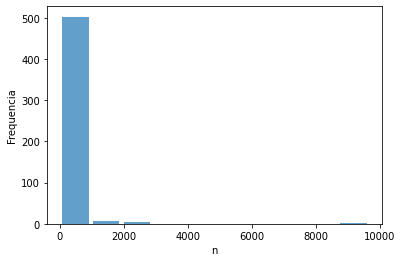

In [ ]:
plt.hist(dados_amostra_br['deaths'], alpha=0.7, rwidth=0.85)
plt.xlabel('n')
plt.ylabel('Frequencia')

Histograma SP

Text(0, 0.5, 'Frequencia')

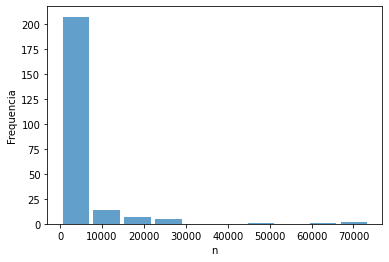

In [ ]:
plt.hist(dados_amostra_sp['totalCases'], alpha=0.7, rwidth=0.85)
plt.xlabel('n')
plt.ylabel('Frequencia')

Text(0, 0.5, 'Frequencia')

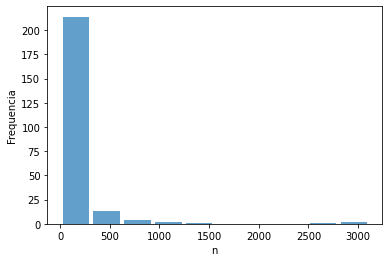

In [ ]:
plt.hist(dados_amostra_sp['deaths'], alpha=0.7, rwidth=0.85)
plt.xlabel('n')
plt.ylabel('Frequencia')